In [1]:
import os
import random
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rocket_rag.transform import smoothing

In [2]:
RAW_DATA_DIR = '../data/raw/'
INSTANCES_DIR = '../data/instances/'
INFERENCE_DIR = '../data/inference/'
STATES = ['normal', 
          'backlash1', 'backlash2',
          'lackLubrication1', 'lackLubrication2',
          'spalling1', 'spalling2', 'spalling3', 'spalling4',
          'spalling5', 'spalling6', 'spalling7', 'spalling8']
LOADS= ['20kg', '40kg', '-40kg']
SMOOTHING_PE_WINDOW_SIZE = 20
SMOOTHING_CUR_WINDOW_SIZE1 = 5
SMOOTHING_CUR_WINDOW_SIZE2 = 10
SMOOTHING_CUR_WINDOW_SIZE3 = 15

In [3]:
random.seed(42)

load_state_dict = {load: [random.sample(os.listdir(os.path.join(INSTANCES_DIR, load, state)), 1) 
                          for state in STATES] for load in LOADS}
# load_state_dict

In [4]:
def extract_data_for_plotting(load: str):
    filenames = [os.path.join(INSTANCES_DIR, load, state, filename) 
                    for state in STATES 
                    for filename in load_state_dict[load][STATES.index(state)]]

    pos_arr, cur_arr = [], []
    for filename in filenames:
        pos_arr.append(smoothing(ts_df=pd.read_csv(filename), field='position_error'))
        cur_arr.append(smoothing(ts_df=pd.read_csv(filename), field='current'))
    
    return pos_arr, cur_arr

In [5]:
def plot_figures(position_errors, currents, load):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 18))

    [ax1.plot(position_errors[i], label=f'{STATES[i]}') for i in range(len(STATES))]
    ax1.set_xlabel('Time')
    ax1.set_xlim(0, len(position_errors[0]))
    ax1.set_xticks([i for i in range(0, len(position_errors[0])) if i % 10 == 0])
    ax1.set_ylabel('Position Error')
    # ax1.set_title(f"Position Errors for Different States ({load})")
    ax1.legend()

    [ax2.plot(currents[i], label=f'{STATES[i]}') for i in range(len(STATES))]
    ax2.set_xlabel('Time')
    ax2.set_xlim(0, len(currents[0]))
    ax2.set_xticks([i for i in range(0, len(currents[0])) if i % 10 == 0])
    ax2.set_ylabel('Current')
    # ax2.set_title(f"Currents for Different States ({load})")
    ax2.legend()

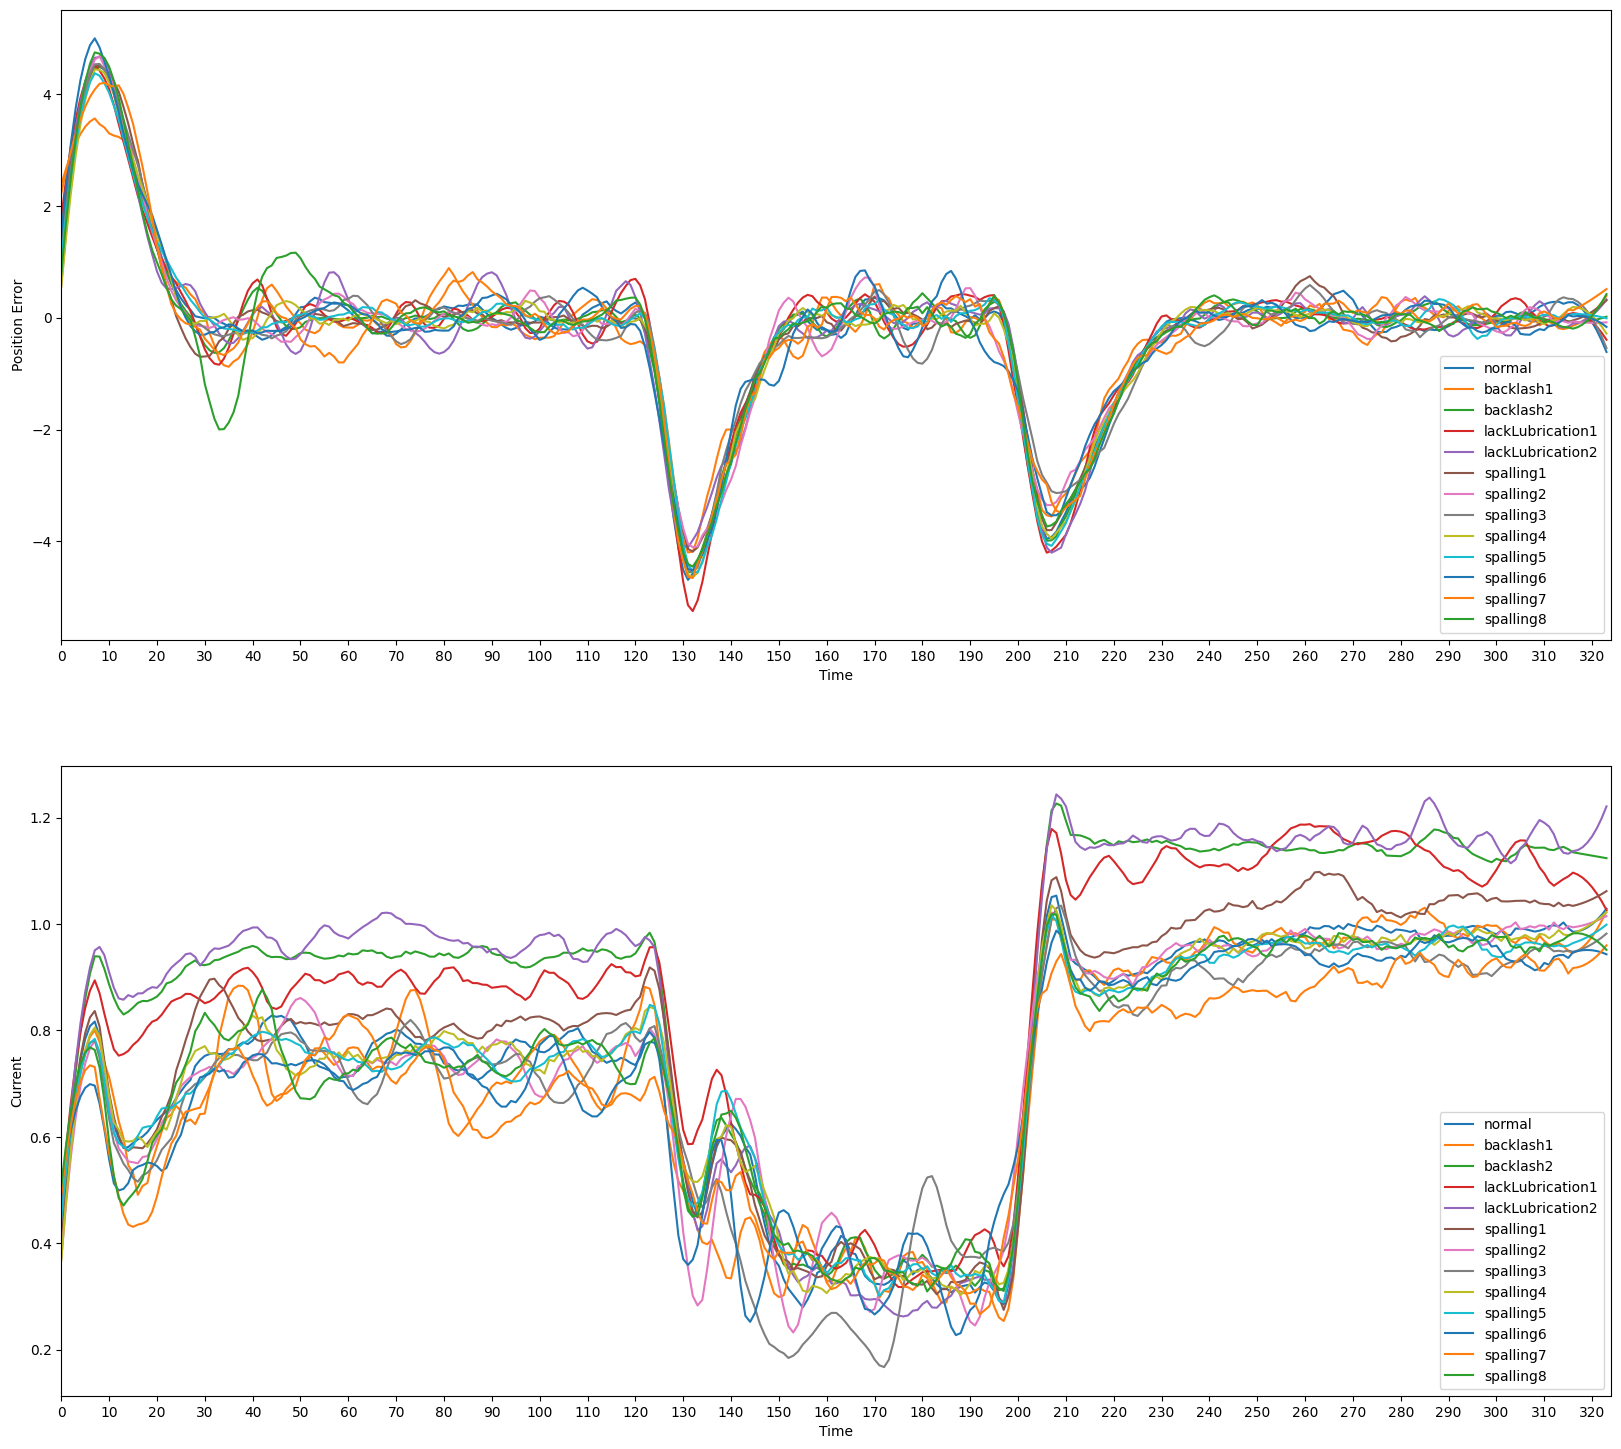

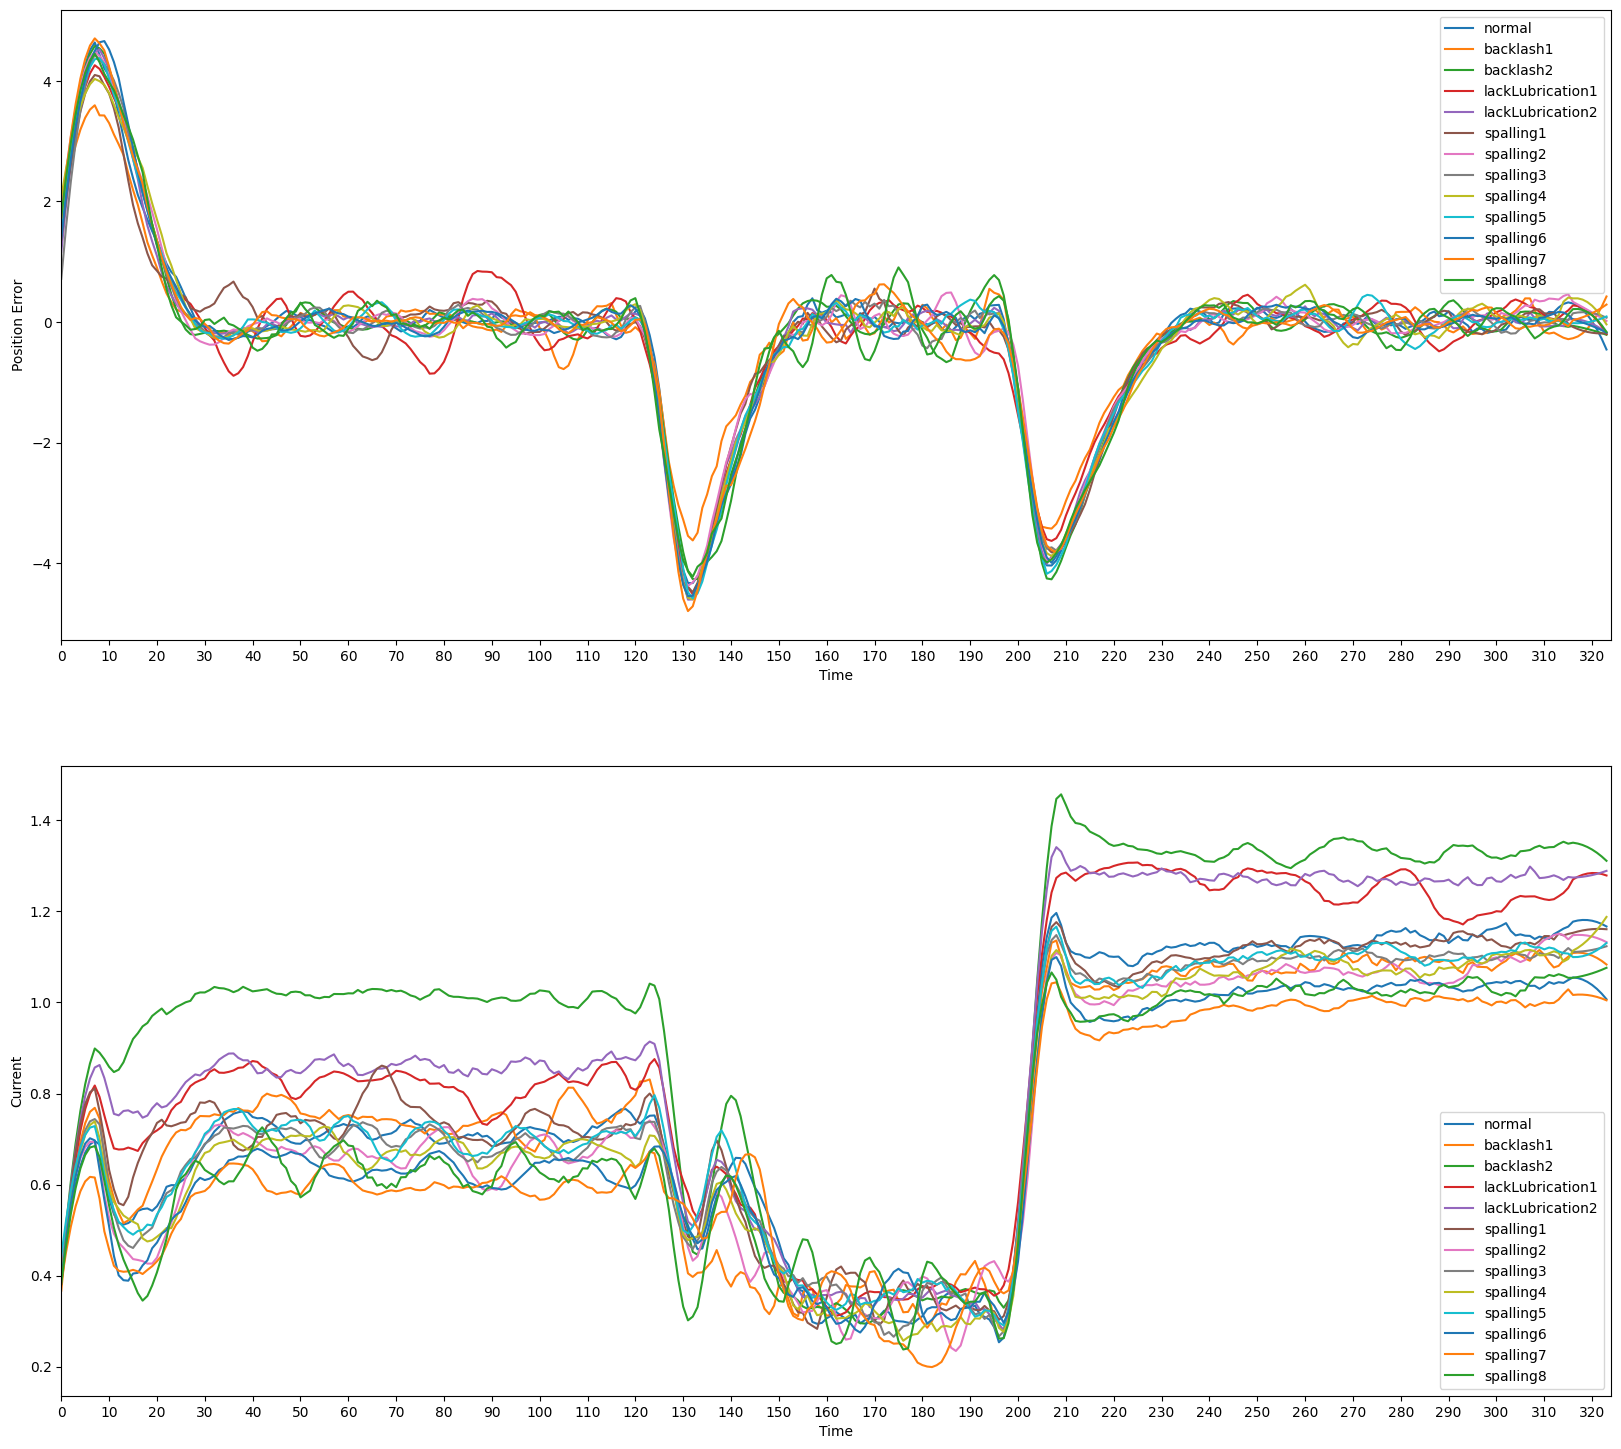

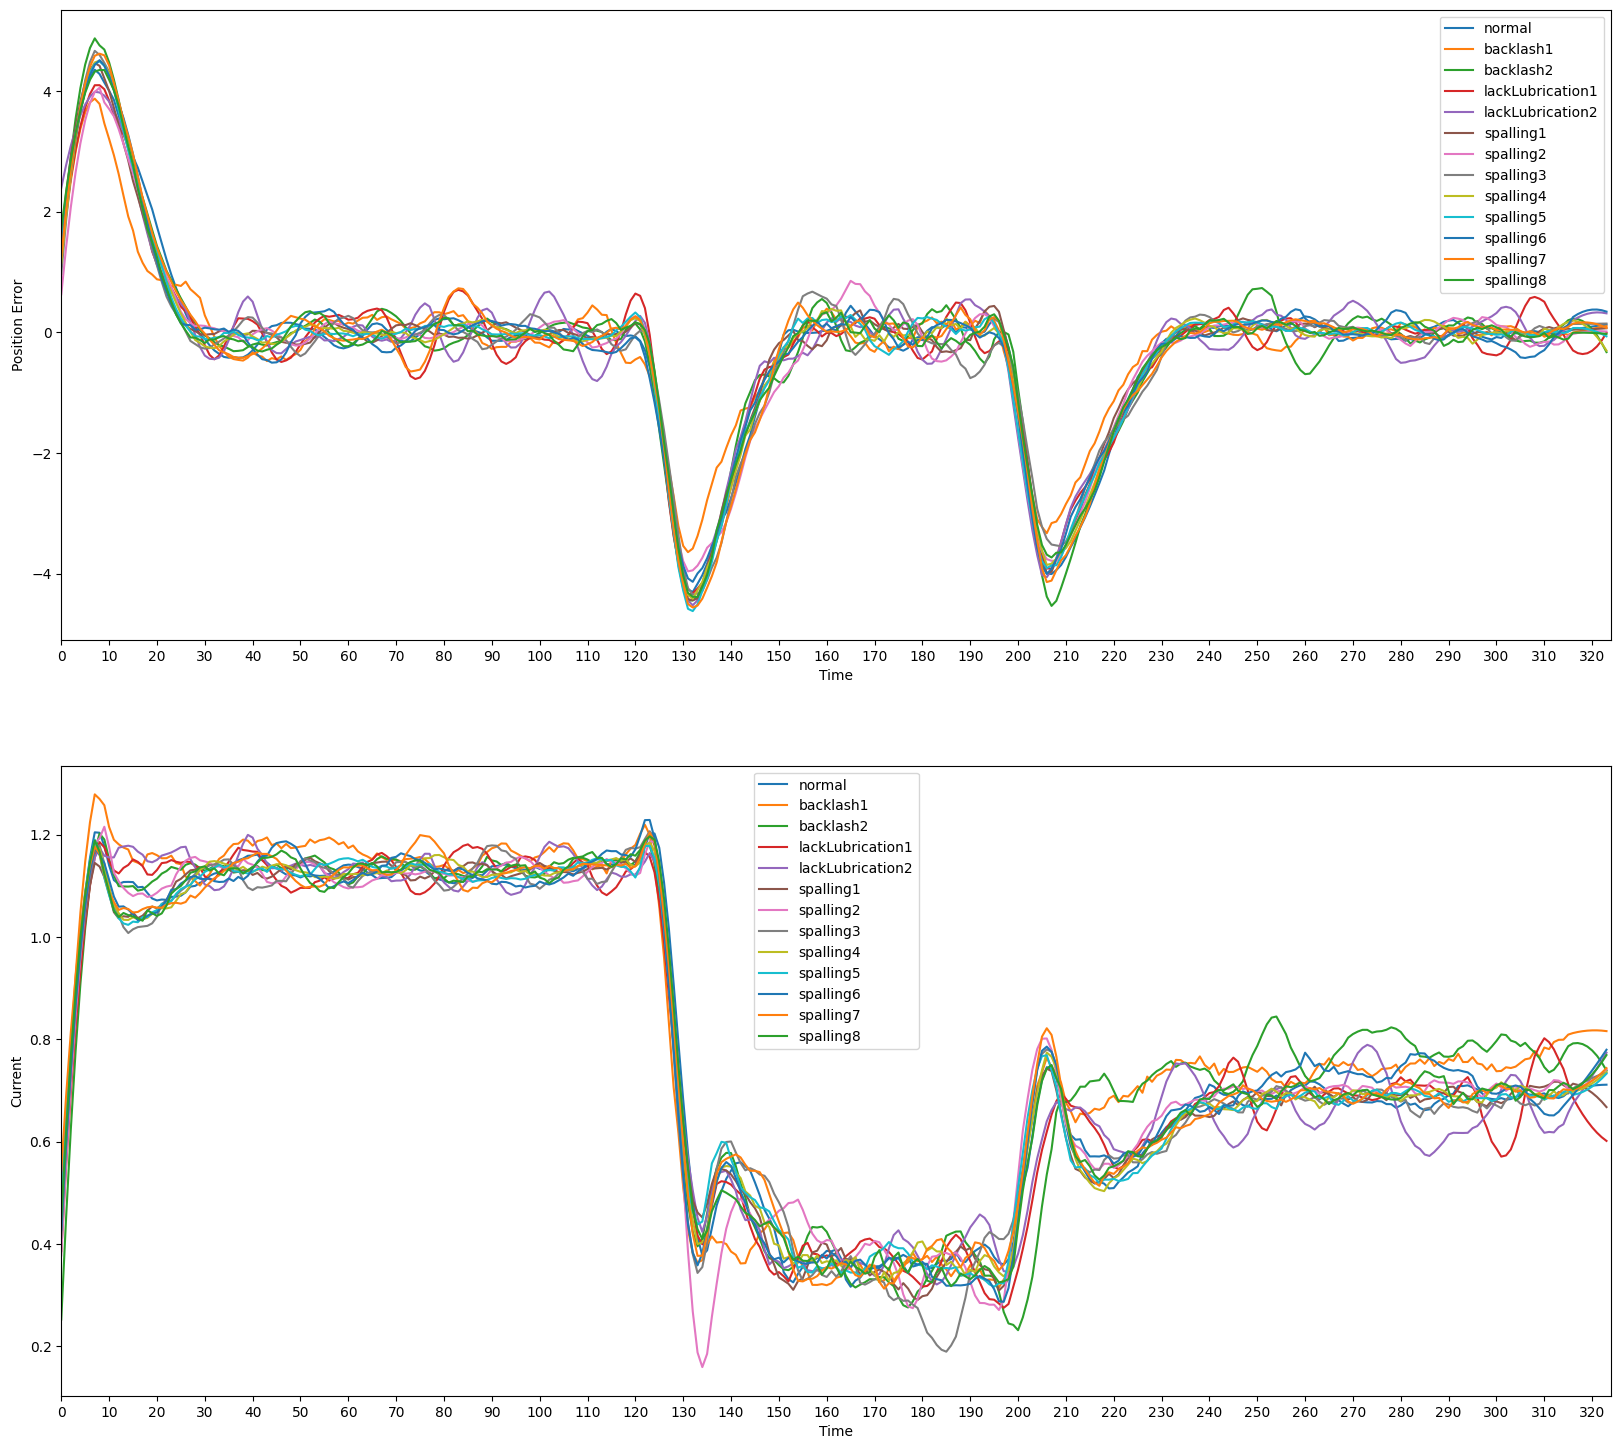

In [6]:
for load in LOADS:
    pos_arr, cur_arr = extract_data_for_plotting(load)
    plot_figures(pos_arr, cur_arr, load=load)

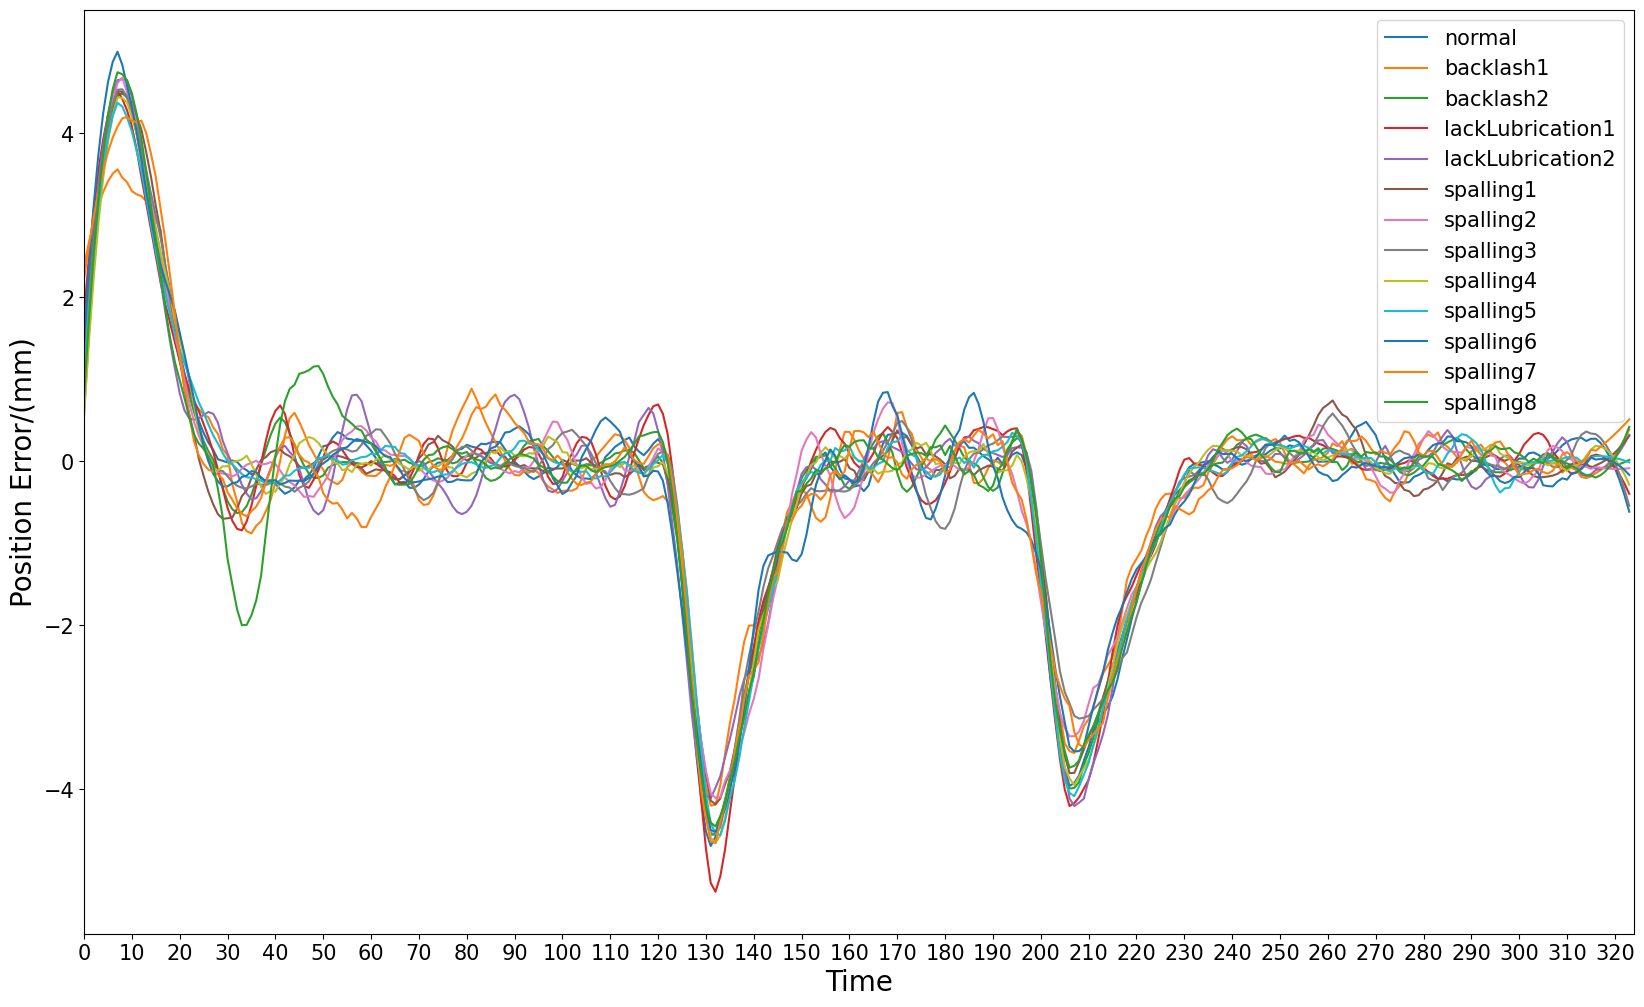

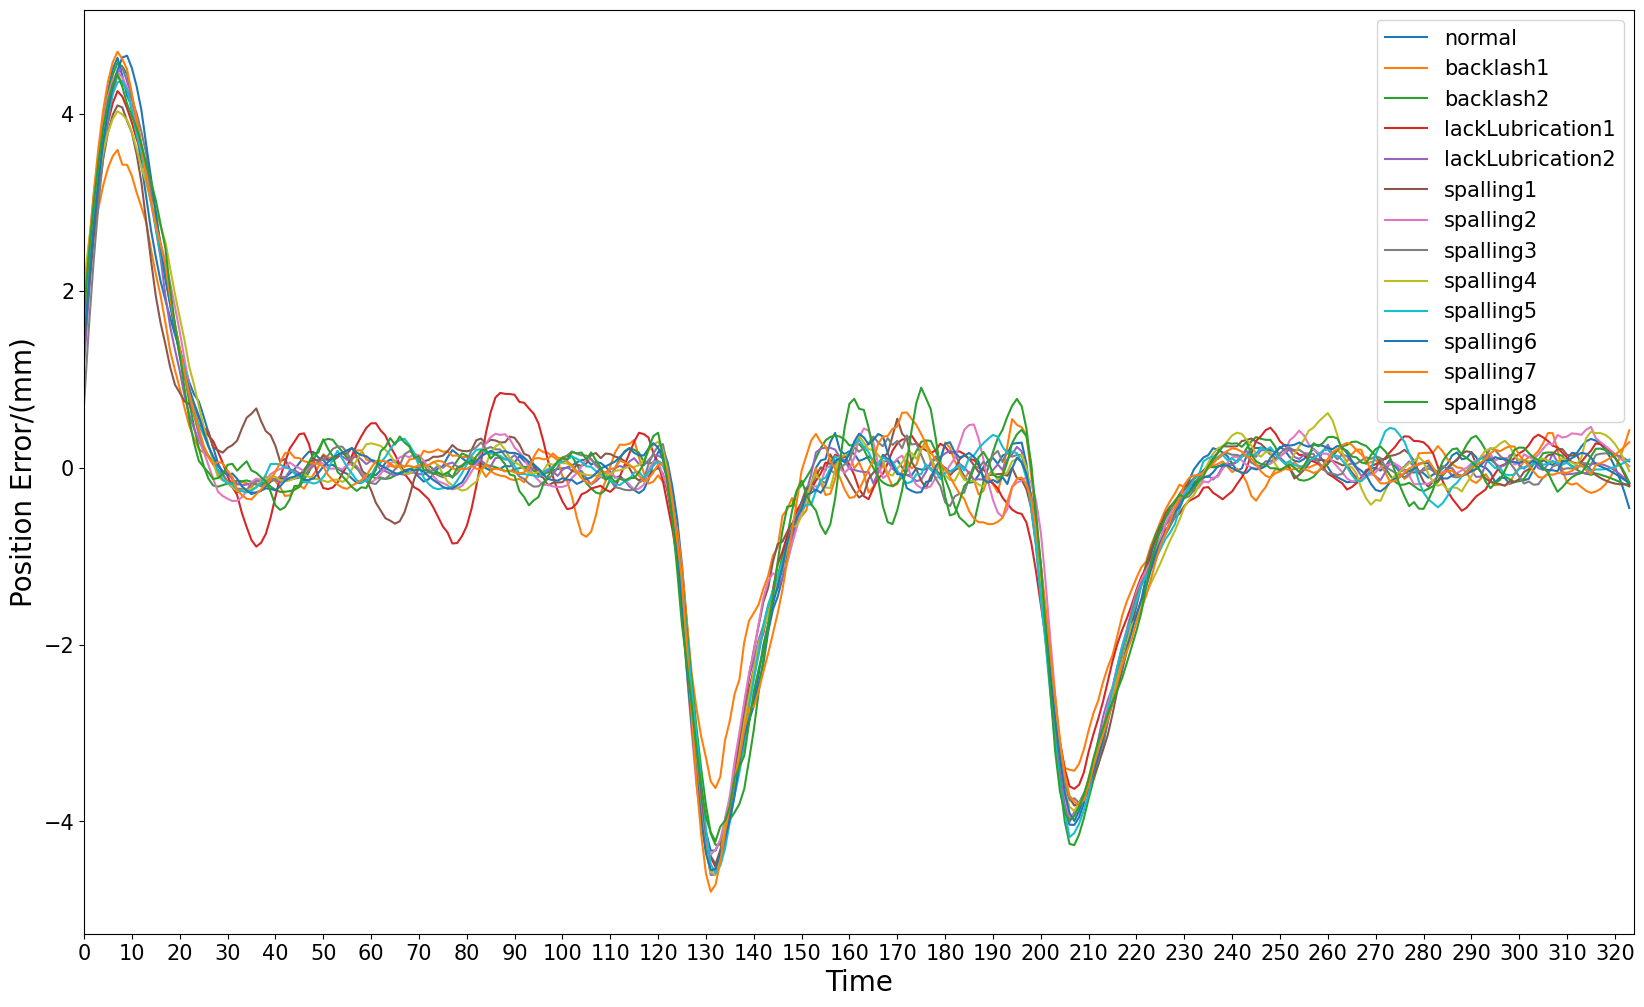

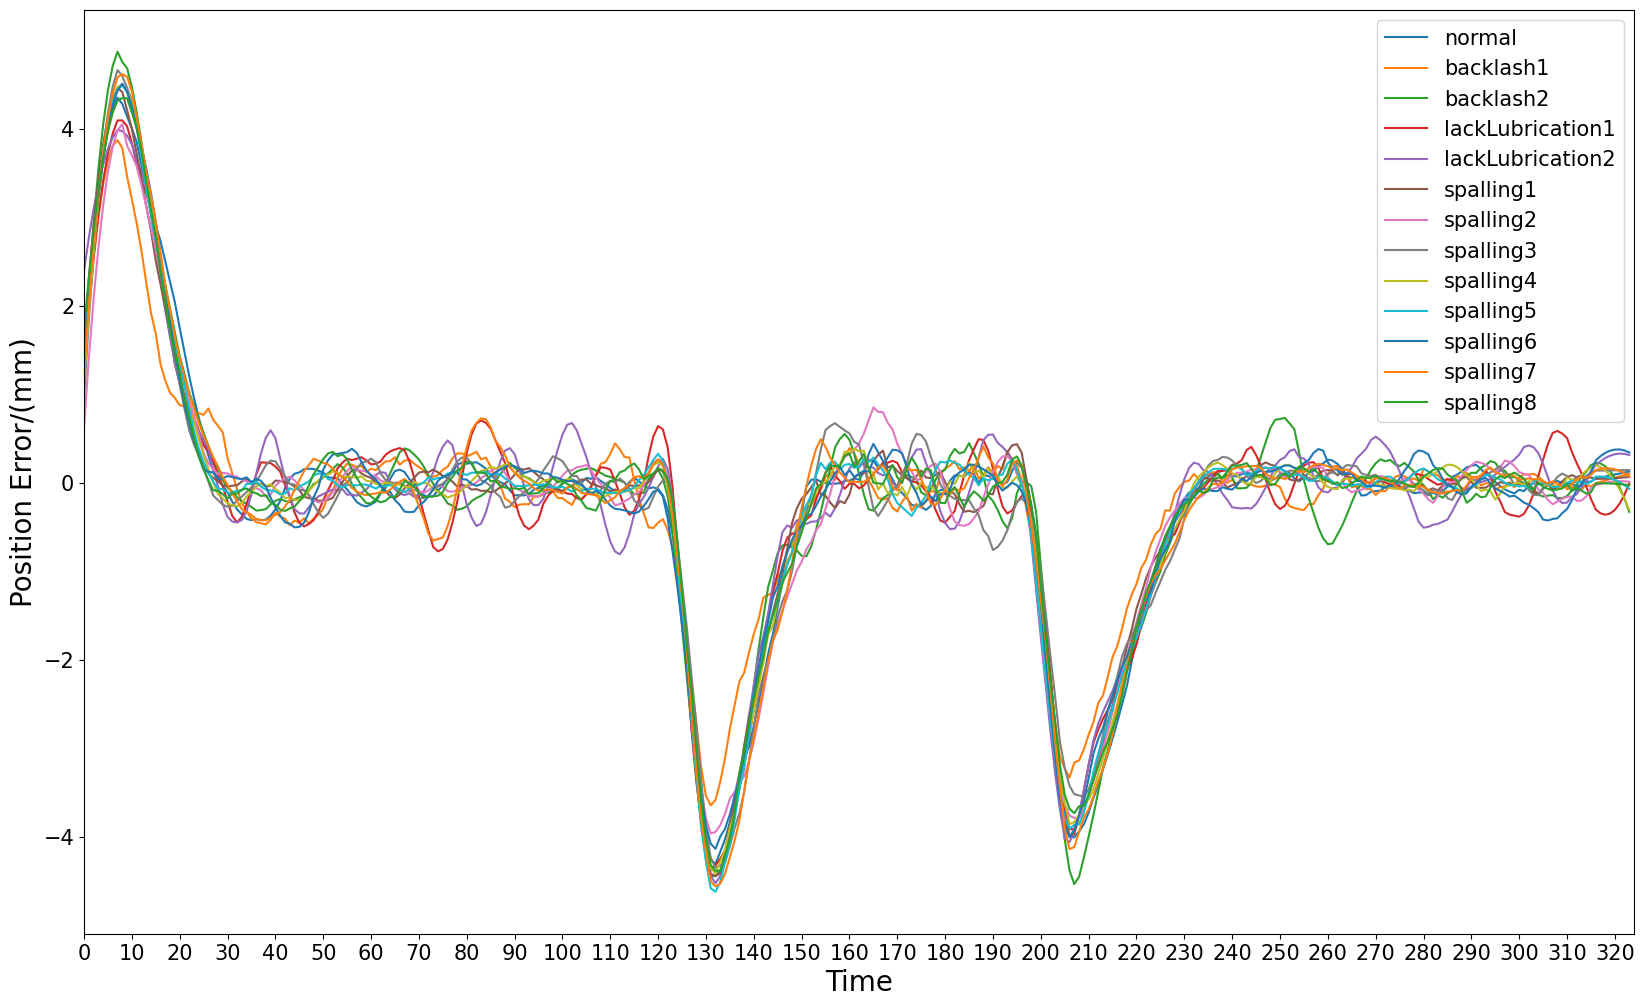

In [7]:
def plot_pos_figures(position_errors):
    plt.figure(figsize=(20, 12))

    [plt.plot(position_errors[i], label=f'{STATES[i]}') for i in range(len(STATES))]
    plt.xlabel('Time', fontsize=20)
    plt.xlim(0, len(position_errors[0]))
    plt.yticks(fontsize=15)
    plt.xticks([i for i in range(0, len(position_errors[0])) if i % 10 == 0], fontsize=15)
    plt.ylabel('Position Error/(mm)', fontsize=20)
    plt.legend(fontsize=15)
    
for load in LOADS:
    pos_arr, _ = extract_data_for_plotting(load)
    plot_pos_figures(pos_arr)

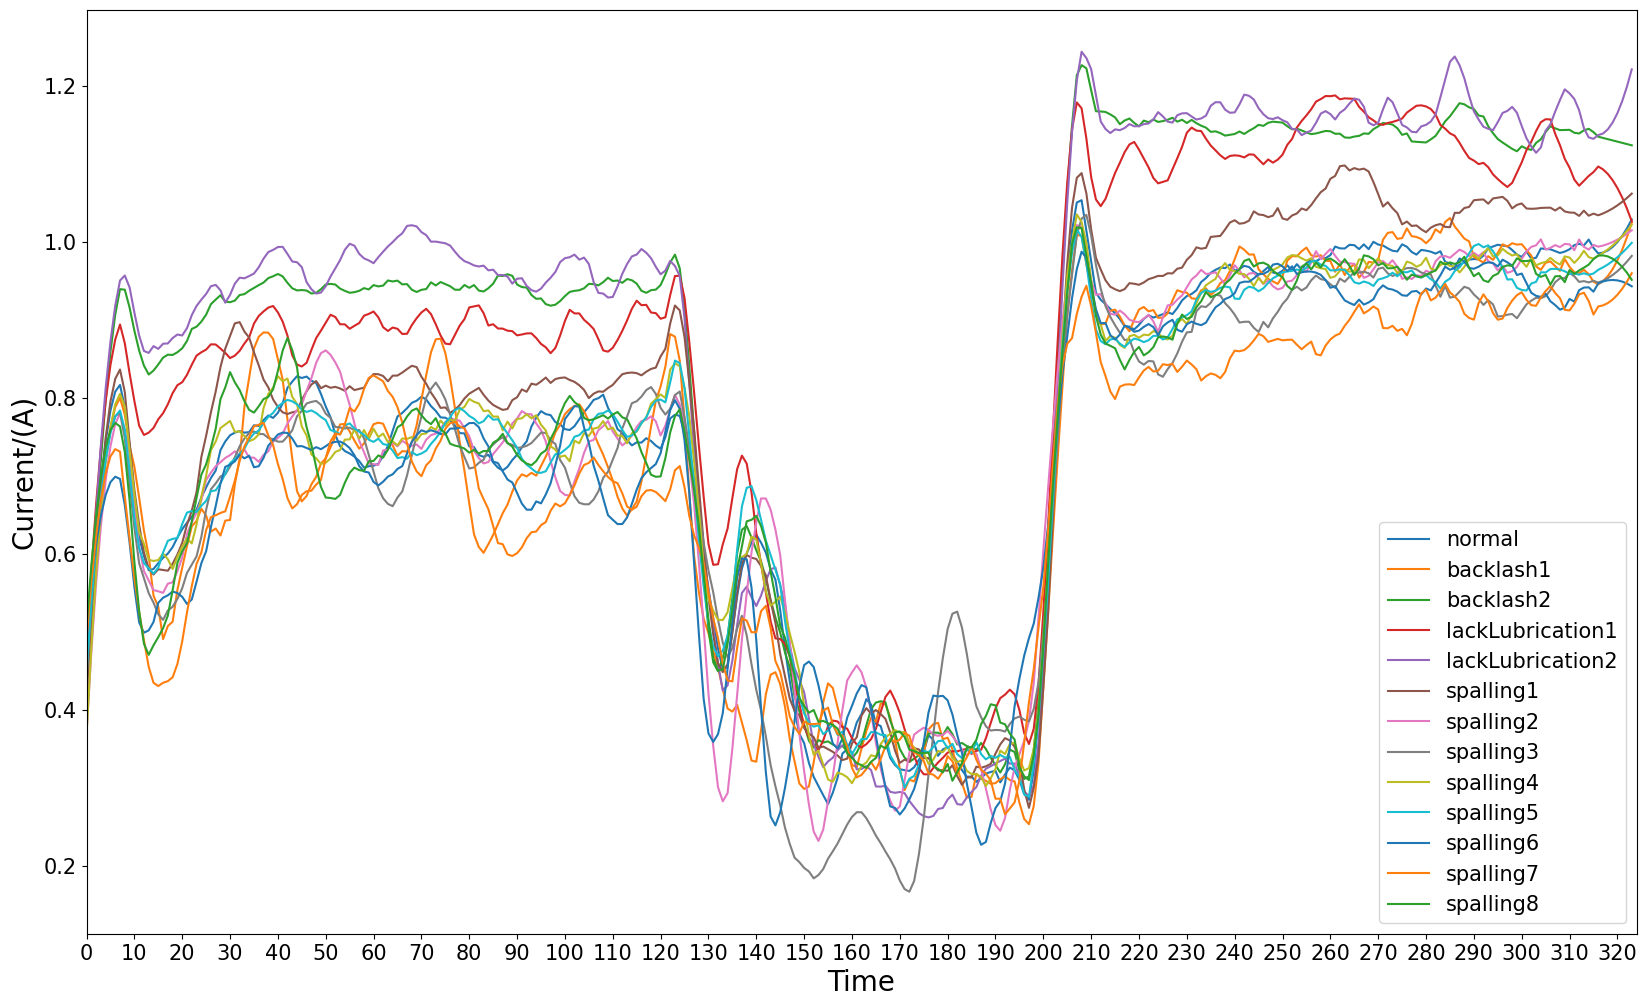

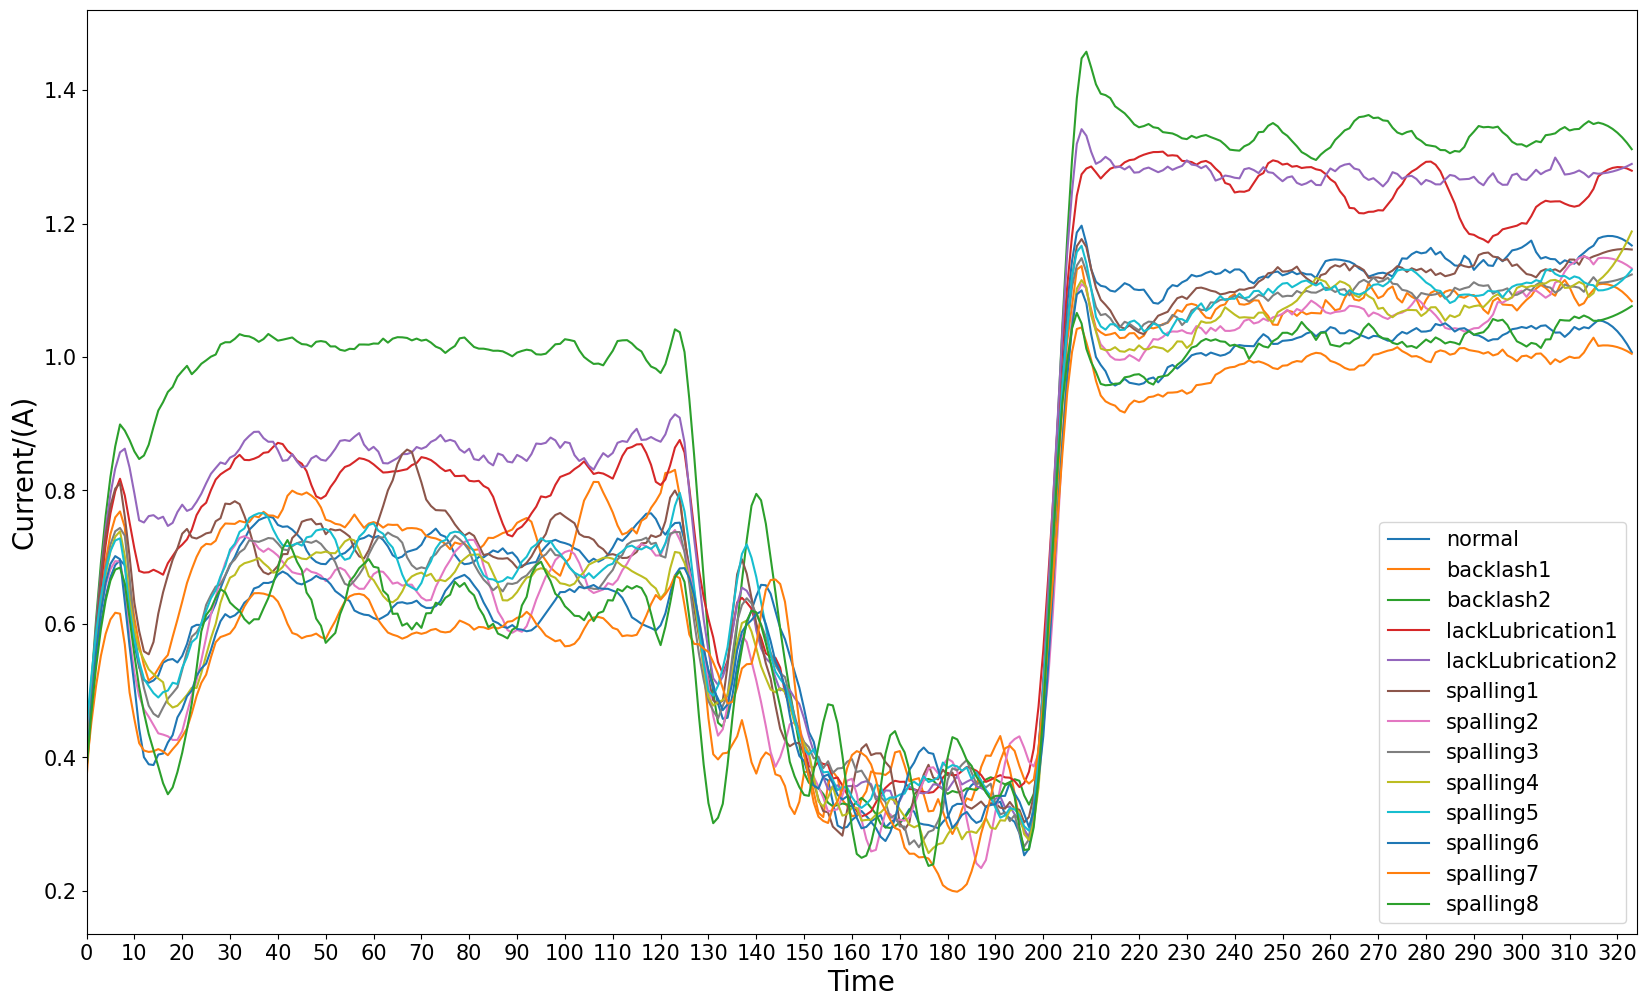

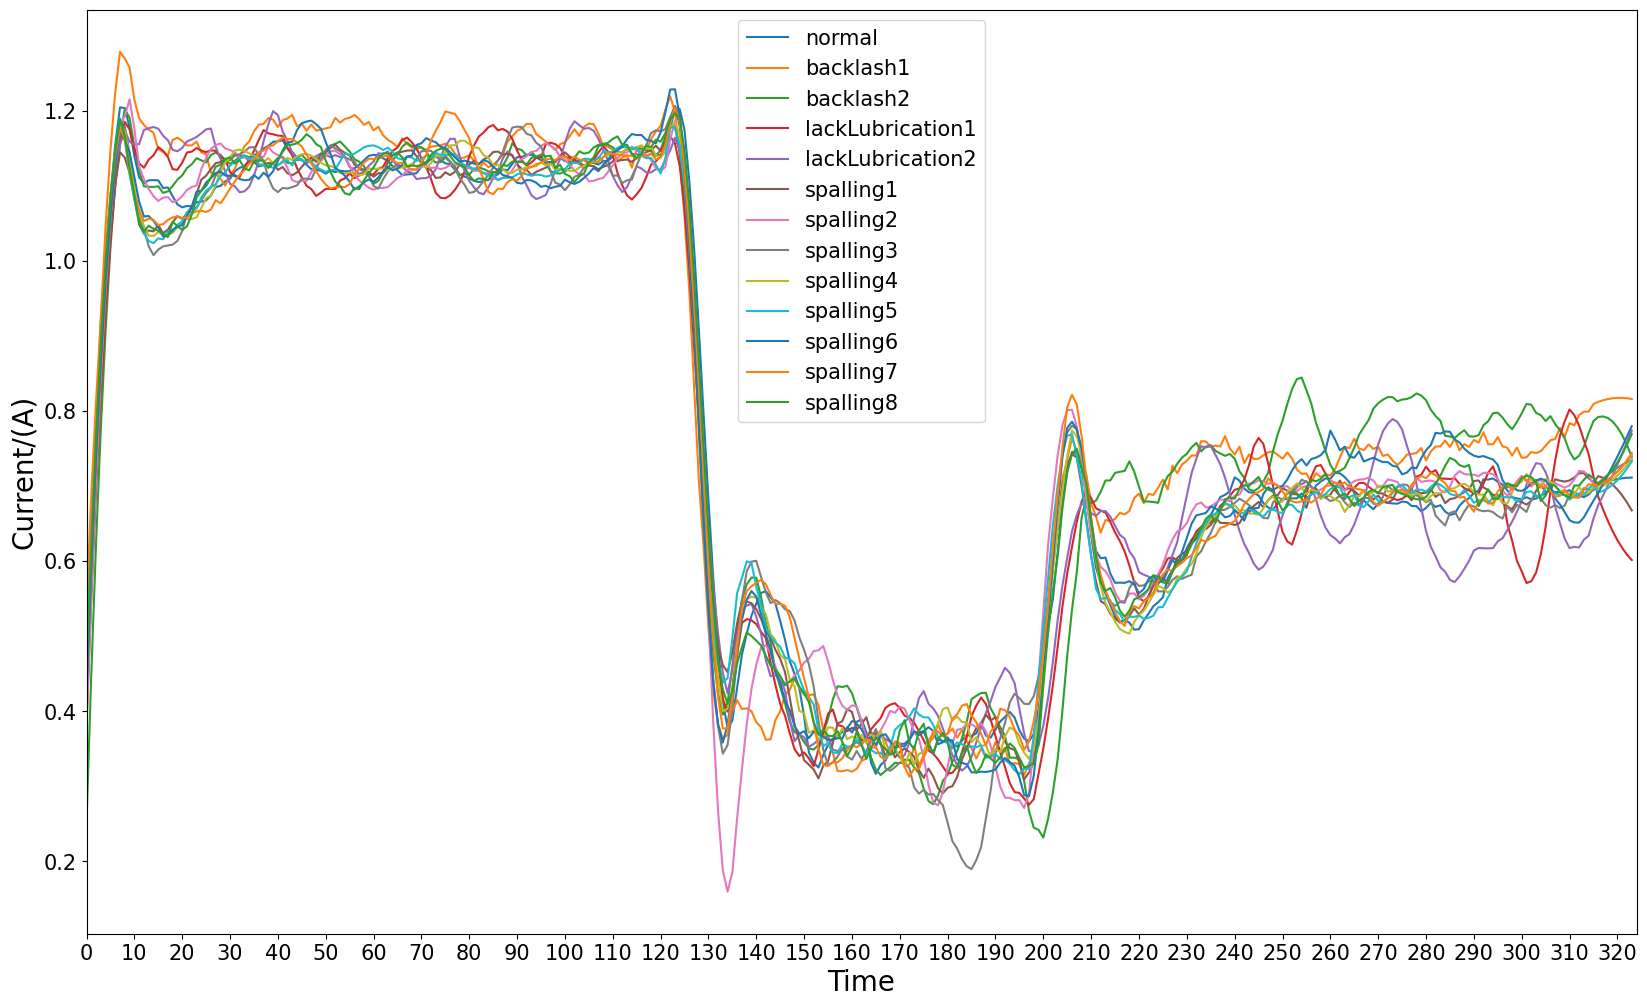

In [8]:
def plot_cur_figures(current):
    plt.figure(figsize=(20, 12))

    [plt.plot(current[i], label=f'{STATES[i]}') for i in range(len(STATES))]
    plt.xlabel('Time', fontsize=20)
    plt.xlim(0, len(current[0]))
    plt.yticks(fontsize=15)
    plt.xticks([i for i in range(0, len(current[0])) if i % 10 == 0], fontsize=15)
    plt.ylabel('Current/(A)', fontsize=20)
    plt.legend(fontsize=15)
    
for load in LOADS:
    _, cur_arr = extract_data_for_plotting(load)
    plot_cur_figures(cur_arr)

In [9]:
all_instances = {str(load) + '_' + str(state): os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES for load in LOADS}

In [10]:
normal_20kg = all_instances['20kg_normal']

In [11]:
random.seed(42)

rand_filename = os.path.join(INSTANCES_DIR, '20kg', 'normal', random.choice(normal_20kg))
time_series = smoothing(pd.read_csv(rand_filename), field='current')

In [12]:
fft_values = np.fft.fft(time_series)
fft_freqs = np.fft.fftfreq(len(time_series))

positive_freq_idx = np.where(fft_freqs >= 0)
fft_values = fft_values[positive_freq_idx]
fft_freq = fft_freqs[positive_freq_idx]

In [13]:
dominant_freq_num = 5
dominant_freq_idx = np.argsort(np.abs(fft_values))[-dominant_freq_num:]
dominant_freq = sorted(fft_freq[dominant_freq_idx])
dominant_magn = sorted(np.abs(fft_values[dominant_freq_idx]), reverse=True)

# Plot the time series and the frequency domain representation
print("Dominant Frequencies (Hz):", dominant_freq)
print("Magnitudes:", dominant_magn)

Dominant Frequencies (Hz): [0.0, 0.0030864197530864196, 0.006172839506172839, 0.009259259259259259, 0.012345679012345678]
Magnitudes: [241.9041291381714, 34.79319442620625, 28.896512585116028, 12.138294190707622, 10.645581561760705]


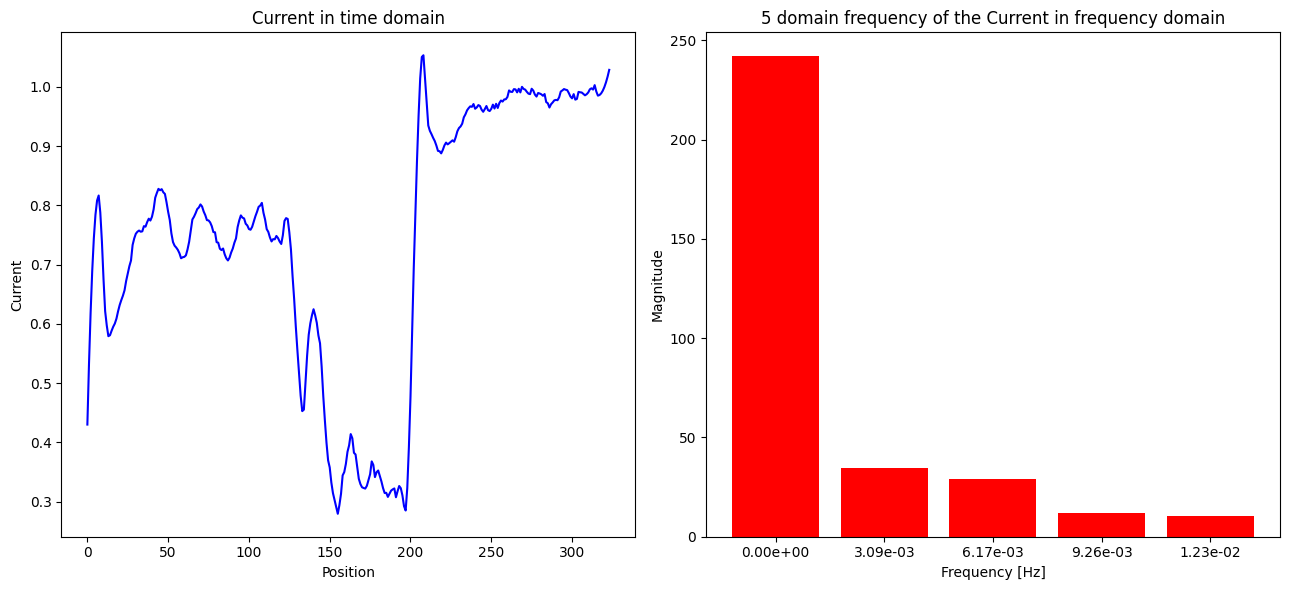

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Plot the first figure on the first subplot (ax1)
ax1.plot(time_series, color='blue')
ax1.set_title('Current in time domain')
ax1.set_xlabel('Position')
ax1.set_ylabel('Current')
# ax1.legend()

# Plot the second figure on the second subplot (ax2)
doamin_freq_str = [f'{freq:.2e}' for freq in dominant_freq]
ax2.bar(doamin_freq_str, dominant_magn, color='red')
ax2.set_title(f'{dominant_freq_num} domain frequency of the Current in frequency domain')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Magnitude')
# ax2.legend()

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show() 

In [15]:
average_dict = {}
for k, v in all_instances.items():    
    load, state = k.split('_')
    # Average all current and position error of 20kgnormal
    if load == '20kg':
        all_files = all_instances[k]
        average_dict[k] = {'current': [], 'position_error': []}

        n_cur = len(pd.read_csv(os.path.join(INSTANCES_DIR, load, state, all_files[0]))['current'])
        n_pos_err = len(pd.read_csv(os.path.join(INSTANCES_DIR, load, state, all_files[0]))['position_error'])

        average_df = {'current': [0] * n_cur, 'position_error': [0] * n_pos_err}

        for filename in all_files:
            df = pd.read_csv(os.path.join(INSTANCES_DIR, load, state, filename))
            average_df['current'] += df['current']
            average_df['position_error'] += df['position_error']

        average_df['current'] = average_df['current'] / len(all_files)
        average_df['position_error'] = average_df['position_error'] / len(all_files)
        
        average_dict[k]['current'] = average_df['current'].tolist()
        average_dict[k]['position_error'] = average_df['position_error'].tolist()

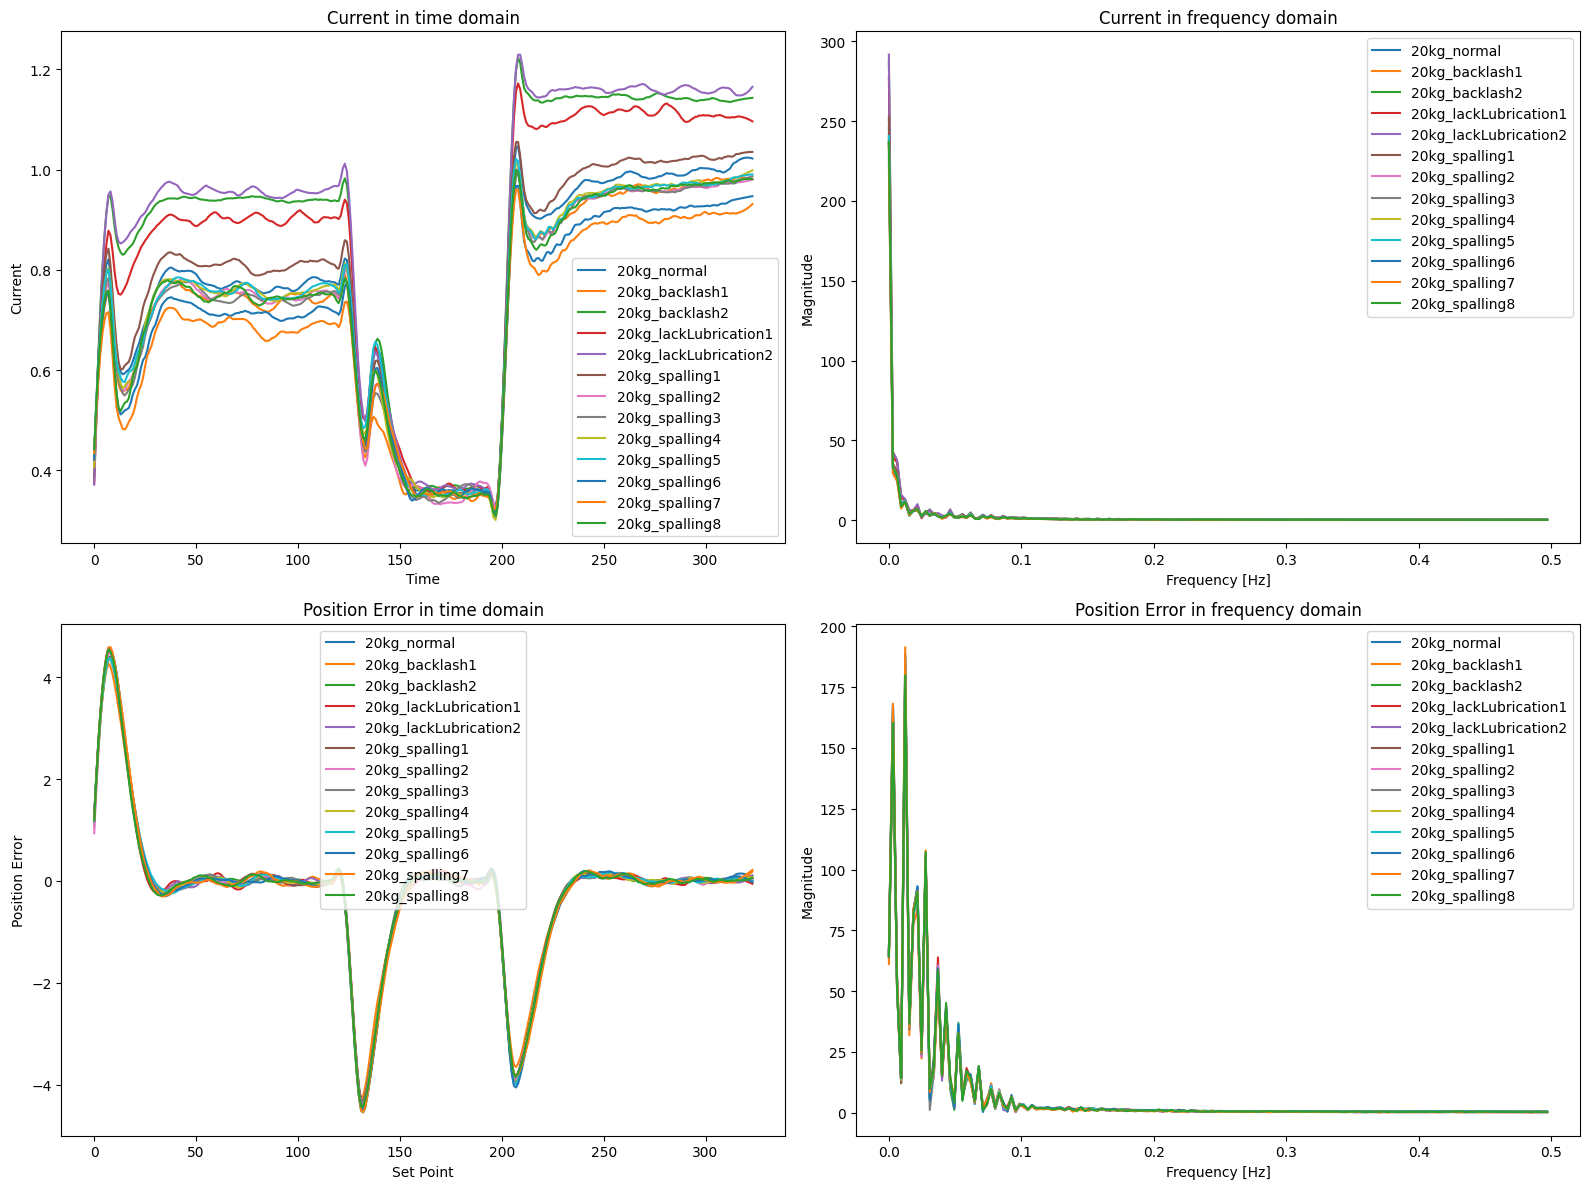

In [16]:
from scipy.signal import savgol_filter

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for k, v in average_dict.items():
    cur = savgol_filter(v['current'], window_length=15, polyorder=2)
    pos_err = savgol_filter(v['position_error'], window_length=15, polyorder=2)

    cur_fft_values = np.fft.fft(cur)
    pos_err_fft_values = np.fft.fft(pos_err)
    cur_fft_freqs = np.fft.fftfreq(len(cur))
    pos_err_fft_freqs = np.fft.fftfreq(len(pos_err))

    cur_positive_freq_idx = np.where(cur_fft_freqs >= 0)
    pos_err_positive_freq_idx = np.where(pos_err_fft_freqs >= 0)
    cur_fft_values = cur_fft_values[cur_positive_freq_idx]
    pos_err_fft_values = pos_err_fft_values[pos_err_positive_freq_idx]
    cur_fft_freq = cur_fft_freqs[positive_freq_idx]
    pos_err_fft_freq = pos_err_fft_freqs[positive_freq_idx]
    
    # Plot on the first subplot (top-left)
    axs[0, 0].plot(cur, label=k)
    axs[0, 0].set_title('Current in time domain')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('Current')
    axs[0, 0].legend()

    # Plot on the second subplot (top-right)
    axs[0, 1].plot(cur_fft_freq, np.abs(cur_fft_values), label=k)
    axs[0, 1].set_title('Current in frequency domain')
    axs[0, 1].set_xlabel('Frequency [Hz]')
    axs[0, 1].set_ylabel('Magnitude')
    axs[0, 1].legend()

    # Plot on the third subplot (bottom-left)
    axs[1, 0].plot(pos_err, label=k)
    axs[1, 0].set_title('Position Error in time domain')
    axs[1, 0].set_xlabel('Set Point')
    axs[1, 0].set_ylabel('Position Error')
    axs[1, 0].legend()

    # Plot on the fourth subplot (bottom-right)
    axs[1, 1].plot(pos_err_fft_freq, np.abs(pos_err_fft_values), label=k)
    axs[1, 1].set_title('Position Error in frequency domain')
    axs[1, 1].set_xlabel('Frequency [Hz]')
    axs[1, 1].set_ylabel('Magnitude')
    axs[1, 1].legend()
    
    
# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()